### Tile Registration and Stitching Pipeline

This notebook registers tile1 to tile0 and stitches them together with minimal blending for sharp results.

In [1]:
# Step 1: Import packages
import numpy as np
import zarr
import os

from bigstream.align import alignment_pipeline
from bigstream.transform import apply_transform
from bigstream.piecewise_align import distributed_piecewise_alignment_pipeline
from bigstream.piecewise_transform import distributed_apply_transform

In [3]:
# Step 2: Load images
src_path = '/path/to/zarr/with/tiles/confocal.zarr/'
output_dir = 'output/directory' # store deformation field, deformed tile1 and stitched image as zarr arrays

fix_zarr = zarr.open(os.path.join(src_path, 'tile0'), mode='r')
mov_zarr = zarr.open(os.path.join(src_path, 'tile1'), mode='r')

fix = fix_zarr['s0'][...]
mov = mov_zarr['s0'][...]

print(f"Tile0 (fixed) shape: {fix.shape}")
print(f"Tile1 (moving) shape: {mov.shape}")

Tile0 (fixed) shape: (269, 2048, 2048)
Tile1 (moving) shape: (269, 2048, 2048)


In [4]:
# Step 3: Define voxel spacing and tile geometry
fix_spacing = np.array([1.0, 0.259, 0.259])  # Z, Y, X in microns
mov_spacing = np.array([1.0, 0.259, 0.259])

# Tile geometry
tile1_y_offset = 1844  # tile1 is 1844 pixels below tile0
overlap_size = fix.shape[1] - tile1_y_offset  # 2048 - 1844 = 204 pixels

print(f"Tile1 Y offset: {tile1_y_offset} pixels")
print(f"Overlap size: {overlap_size} pixels")

Tile1 Y offset: 1844 pixels
Overlap size: 204 pixels


In [ ]:
# Step 4: Create initial affine with known offsets
# offset was acquired by running phase correlation on tile1 and tile0 
z_offset_pixels = 5
y_offset_pixels = tile1_y_offset  # 1844
x_offset_pixels = 10

# Convert to physical units
z_offset_physical = z_offset_pixels * fix_spacing[0]
y_offset_physical = y_offset_pixels * fix_spacing[1]
x_offset_physical = x_offset_pixels * fix_spacing[2]

# Build initial affine (negative translation to shift tile1 up to align with tile0)
initial_affine = np.array([
    [1, 0, 0, -z_offset_physical],
    [0, 1, 0, -y_offset_physical],
    [0, 0, 1, -x_offset_physical],
    [0, 0, 0, 1]
], dtype=np.float64)

print("Initial affine transform:")
print(initial_affine)
print(f"\nTranslations (pixels): Z={-z_offset_pixels}, Y={-y_offset_pixels}, X={-x_offset_pixels}")

final_affine = initial_affine
print("Final affine")
print(final_affine)

Initial affine transform:
[[   1.       0.       0.      -5.   ]
 [   0.       1.       0.    -477.596]
 [   0.       0.       1.      -2.59 ]
 [   0.       0.       0.       1.   ]]

Translations (pixels): Z=-5, Y=-1844, X=-10


In [ ]:
# step 4.5 
# in case we need an affine transformation first

from bigstream.align import alignment_pipeline

affine_kwargs = {
    'alignment_spacing': 2.0,
    'shrink_factors': [4, 2, 1],
    'smooth_sigmas': [4, 2, 0],
    'optimizer_args': {
        'learningRate': 0.1,
        'minStep': 0.0,
        'numberOfIterations': 200,
    },
}

steps = [('affine', affine_kwargs)]

affine = alignment_pipeline(
    fix, mov,
    fix_spacing, mov_spacing,
    steps,
    static_transform_list=[initial_affine],
)

print("Refined affine:")
print(affine)

# Compose transforms
final_affine = affine @ initial_affine
print(f"\nFinal Y translation: {final_affine[1, 3]:.1f} µm ({final_affine[1, 3] / fix_spacing[1]:.0f} pixels)")


In [6]:
# Step 5: Create full canvas for registration
# Canvas covers tile0 (Y=0:2048) + tile1 extension (Y=2048:3892)
canvas_y_size = tile1_y_offset + mov.shape[1]  # 1844 + 2048 = 3892
canvas_shape = (fix.shape[0], canvas_y_size, fix.shape[2])

print(f"Canvas shape: {canvas_shape}")

# Create fix_canvas:
# - Y=0:2048: tile0 data
# - Y=2048:3892: tile1 data (so deformation -> identity there)
fix_canvas = np.zeros(canvas_shape, dtype=fix.dtype)
fix_canvas[:, :fix.shape[1], :] = fix  # Place tile0

# Create mov_canvas: apply affine to place tile1 at Y=1844:3892
mov_canvas = apply_transform(
    fix_canvas, mov,
    fix_spacing, mov_spacing,
    transform_list=[final_affine],
)

# Fill fix_canvas non-overlap region (Y=2048:3892) with tile1 data
# This ensures deformation -> 0 in non-overlap region
fix_canvas[:, fix.shape[1]:, :] = mov_canvas[:, fix.shape[1]:, :]

print(f"fix_canvas created")
print(f"mov_canvas created")
print(f"\nOverlap region (Y={tile1_y_offset}:{fix.shape[1]}):")
print(f"  fix_canvas max: {fix_canvas[:, tile1_y_offset:fix.shape[1], :].max()}")
print(f"  mov_canvas max: {mov_canvas[:, tile1_y_offset:fix.shape[1], :].max()}")

Canvas shape: (269, 3892, 2048)
fix_canvas created
mov_canvas created

Overlap region (Y=1844:2048):
  fix_canvas max: 65535
  mov_canvas max: 65535


In [7]:
# Step 6: Create mask to skip tile0-only region
# Mask = 1 where tile1 exists (Y >= 1844), 0 elsewhere
mask = np.zeros(canvas_shape, dtype=np.uint8)
mask[:, tile1_y_offset:, :] = 1

foreground_voxels = mask.sum()
total_voxels = mask.size
print(f"Mask created")
print(f"Foreground voxels: {foreground_voxels:,} / {total_voxels:,} ({100*foreground_voxels/total_voxels:.1f}%)")
print(f"Skipping {100*(1 - foreground_voxels/total_voxels):.1f}% of blocks")

Mask created
Foreground voxels: 1,128,267,776 / 2,144,149,504 (52.6%)
Skipping 47.4% of blocks


In [1]:
# Step 7: Save arrays to zarr for distributed processing
# zarr.save(f'{output_dir}/fix_canvas.zarr', fix_canvas)
# zarr.save(f'{output_dir}/mov_canvas.zarr', mov_canvas)
# zarr.save(f'{output_dir}/canvas_mask.zarr', mask)

# fix_canvas_zarr = zarr.open(f'{output_dir}/fix_canvas.zarr', mode='r')
# mov_canvas_zarr = zarr.open(f'{output_dir}/mov_canvas.zarr', mode='r')
# mask_zarr = zarr.open(f'{output_dir}/canvas_mask.zarr', mode='r')

# print(f"Saved to {output_dir}")
# print(f"  fix_canvas.zarr: {fix_canvas_zarr.shape}")
# print(f"  mov_canvas.zarr: {mov_canvas_zarr.shape}")
# print(f"  canvas_mask.zarr: {mask_zarr.shape}")

In [9]:
# Step 8: Run distributed deformable registration
cluster_kwargs = {
    'config': {
        'distributed.worker.memory.target': 0.9,
        'distributed.worker.memory.spill': 0.9,
        'distributed.worker.memory.pause': 0.9,
    },
    'cluster_type': 'janelia_lsf_cluster',
    'ncpus': 4,
    'processes': 1,
    'threads': 1,
    'min_workers': 2,
    'max_workers': 60,
    'job_extra_directives': ['-P project_name'],
    'log_directory': './debug_job_logs',
}

deform_kwargs = {
    'control_point_spacing': 25.0,
    'control_point_levels': (4, 2, 1),
    'shrink_factors': (4, 2, 1),
    'smooth_sigmas': (2.0, 1.0, 0.5),
    'optimizer_args': {
        'learningRate': 1.0,
        'minStep': 0.0,
        'numberOfIterations': 50,
    },
    'alignment_spacing': 1.0,
}

steps = [('deform', deform_kwargs)]

deform_canvas = distributed_piecewise_alignment_pipeline(
    fix_canvas_zarr, mov_canvas_zarr,
    fix_spacing, fix_spacing,
    steps=steps,
    blocksize=[128, 128, 128],
    fix_mask=mask_zarr,
    foreground_percentage=0.1,
    write_path=f'{output_dir}/deform_field.zarr',
    cluster_kwargs=cluster_kwargs,
)

print(f"\nDeformation field computed!")
print(f"Shape: {deform_canvas.shape}")

Cluster dashboard link:  http://10.36.107.27:8787/status
Cluster adapting between 2 and 60 workers with 4 cores per worker
*** This cluster has an upper bound cost of 16.8 dollars per hour ***

Deformation field computed!
Shape: (269, 3892, 2048, 3)


In [13]:
# Step 9: Inspect deformation field
deform_arr = deform_canvas[...]#zarr.open(f'{output_dir}/deform_field.zarr', mode='r')[...]

print(f"Deformation field shape: {deform_arr.shape}")
print(f"Overall - Min: {deform_arr.min():.2f}, Max: {deform_arr.max():.2f}")

# Check overlap region (Y=1844:2048)
overlap_deform = deform_arr[:, tile1_y_offset:fix.shape[1], :, :]
print(f"\nOverlap region (Y={tile1_y_offset}:{fix.shape[1]}):")
print(f"  Min: {overlap_deform.min():.2f}, Max: {overlap_deform.max():.2f}")
print(f"  Mean |displacement|: {np.abs(overlap_deform).mean():.2f}")

# Check non-overlap region (Y=2048:3892) - should be ~0
non_overlap_deform = deform_arr[:, fix.shape[1]:, :, :]
print(f"\nNon-overlap region (Y={fix.shape[1]}:):")
print(f"  Min: {non_overlap_deform.min():.2f}, Max: {non_overlap_deform.max():.2f}")
print(f"  Mean |displacement|: {np.abs(non_overlap_deform).mean():.2f}")

Deformation field shape: (269, 3892, 2048, 3)
Overall - Min: -8.77, Max: 5.15

Overlap region (Y=1844:2048):
  Min: -8.77, Max: 5.15
  Mean |displacement|: 1.71

Non-overlap region (Y=2048:):
  Min: -4.70, Max: 2.17
  Mean |displacement|: 0.02


In [16]:
# Step 10: Apply deformation to mov_canvas
cluster_kwargs = {
    'config': {
        'distributed.worker.memory.target': 0.9,
        'distributed.worker.memory.spill': 0.9,
        'distributed.worker.memory.pause': 0.9,
    },
    'cluster_type': 'janelia_lsf_cluster',
    'ncpus': 4,
    'processes': 1,
    'threads': 1,
    'min_workers': 2,
    'max_workers': 60,
    'job_extra_directives': ['-P project_name'],
    'log_directory': './debug_job_logs',
}

#deform_canvas_zarr = zarr.open(f'{output_dir}/deform_field.zarr', mode='r')

mov_deformed = distributed_apply_transform(
    fix_canvas_zarr, mov_canvas_zarr,
    fix_spacing, fix_spacing,
    transform_list=[deform_canvas],
    transform_spacing=(fix_spacing,),
    blocksize=(128, 128, 128),
    write_path=f'{output_dir}/mov_deformed.zarr',
    cluster_kwargs=cluster_kwargs,
)

print(f"Deformed mov_canvas shape: {mov_deformed.shape}")

Cluster dashboard link:  http://10.36.107.27:8787/status
Cluster adapting between 2 and 60 workers with 4 cores per worker
*** This cluster has an upper bound cost of 16.8 dollars per hour ***
Deformed mov_canvas shape: (269, 3892, 2048)


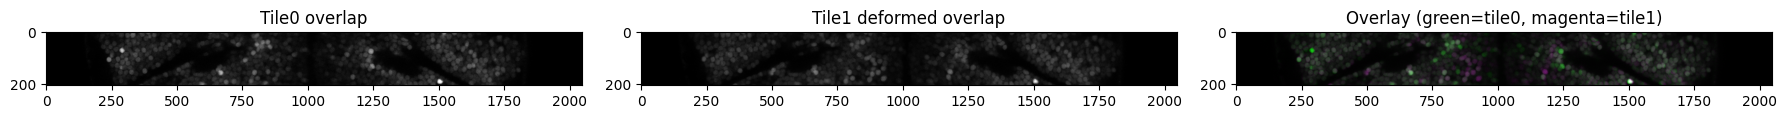

In [18]:
# Step 11: Visualize registration quality in overlap region
import matplotlib.pyplot as plt

#mov_deformed_arr = zarr.open(f'{output_dir}/mov_deformed.zarr', mode='r')

z = fix.shape[0] // 2

# Show overlap region
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

fix_overlap = fix_canvas[z, tile1_y_offset:fix.shape[1], :]
mov_overlap = mov_deformed[z, tile1_y_offset:fix.shape[1], :]

axes[0].imshow(fix_overlap, cmap='gray')
axes[0].set_title('Tile0 overlap')

axes[1].imshow(mov_overlap, cmap='gray')
axes[1].set_title('Tile1 deformed overlap')

# Overlay
overlay = np.zeros((*fix_overlap.shape, 3), dtype=np.float32)
overlay[..., 1] = fix_overlap / fix_overlap.max() if fix_overlap.max() > 0 else 0
overlay[..., 0] = mov_overlap / mov_overlap.max() if mov_overlap.max() > 0 else 0
overlay[..., 2] = mov_overlap / mov_overlap.max() if mov_overlap.max() > 0 else 0
axes[2].imshow(overlay)
axes[2].set_title('Overlay (green=tile0, magenta=tile1)')

plt.tight_layout()
plt.show()

In [26]:
# Step 12: Stitch with narrow blend zone for sharp results (FIXED)

seam_position = overlap_size #// 2  # Middle of overlap
blend_width = 20

seam_y = tile1_y_offset + seam_position
blend_start = seam_y - blend_width // 2
blend_end = seam_y + blend_width // 2

print(f"Blend zone: Y={blend_start}:{blend_end}")

# Create stitched output
stitched = np.zeros(canvas_shape, dtype=fix.dtype)

# Region 1: tile0 up to blend start (not seam!)
stitched[:, :blend_start, :] = fix_canvas[:, :blend_start, :]

# Region 2: Blend zone
weights = np.linspace(1, 0, blend_width).reshape(1, -1, 1)
fix_blend = fix_canvas[:, blend_start:blend_end, :].astype(np.float32)
mov_blend = mov_deformed[:, blend_start:blend_end, :].astype(np.float32)
blended = fix_blend * weights + mov_blend * (1 - weights)
stitched[:, blend_start:blend_end, :] = np.clip(blended, 0, np.iinfo(fix.dtype).max).astype(fix.dtype)

# Region 3: tile1 after blend end (not seam!)
stitched[:, blend_end:, :] = mov_deformed[:, blend_end:, :]

print(f"  Region 1 (tile0): Y=0:{blend_start}")
print(f"  Region 2 (blend): Y={blend_start}:{blend_end}")
print(f"  Region 3 (tile1): Y={blend_end}:{canvas_shape[1]}")


Blend zone: Y=2038:2058
  Region 1 (tile0): Y=0:2038
  Region 2 (blend): Y=2038:2058
  Region 3 (tile1): Y=2058:3892


In [ ]:
# Step 13: Save stitched result
zarr.save(f'{output_dir}/stitched.zarr', stitched)
print(f"Saved stitched result to {output_dir}/stitched.zarr")
print(f"Shape: {stitched.shape}, dtype: {stitched.dtype}")

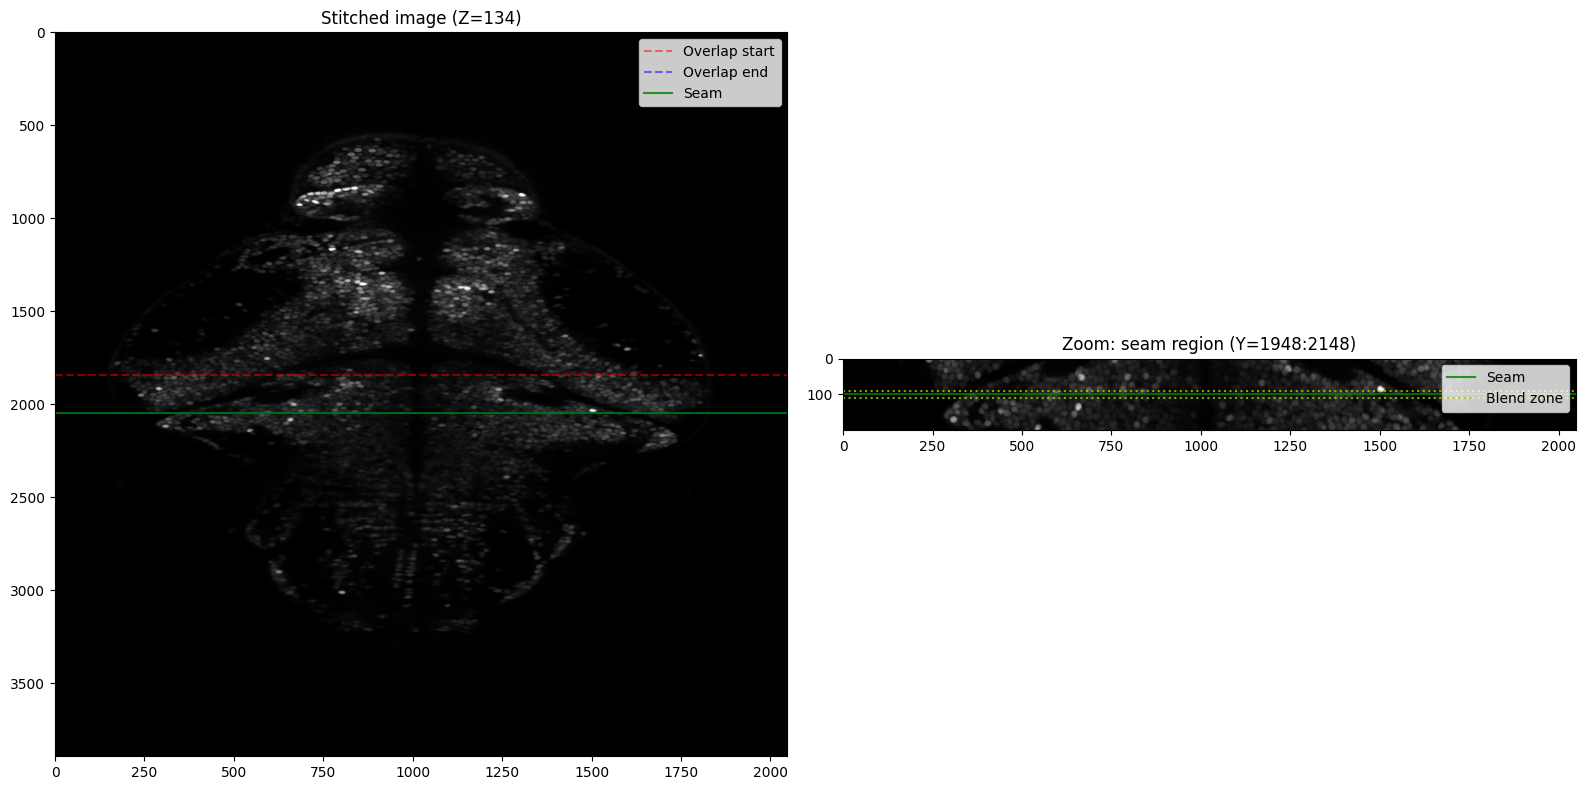

In [21]:
# Step 14: Visualize stitched result
import matplotlib.pyplot as plt

z = stitched.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Full stitched image
axes[0].imshow(stitched[z], cmap='gray', aspect='auto')
axes[0].axhline(y=tile1_y_offset, color='r', linestyle='--', alpha=0.5, label='Overlap start')
axes[0].axhline(y=fix.shape[1], color='b', linestyle='--', alpha=0.5, label='Overlap end')
axes[0].axhline(y=seam_y, color='g', linestyle='-', alpha=0.8, label='Seam')
axes[0].set_title(f'Stitched image (Z={z})')
axes[0].legend()

# Zoom into seam region
zoom_start = seam_y - 100
zoom_end = seam_y + 100
axes[1].imshow(stitched[z, zoom_start:zoom_end, :], cmap='gray')
axes[1].axhline(y=100, color='g', linestyle='-', alpha=0.8, label='Seam')
axes[1].axhline(y=100 - blend_width//2, color='y', linestyle=':', alpha=0.8, label='Blend zone')
axes[1].axhline(y=100 + blend_width//2, color='y', linestyle=':', alpha=0.8)
axes[1].set_title(f'Zoom: seam region (Y={zoom_start}:{zoom_end})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Optional: Adjust seam_position and blend_width if needed
# Re-run Steps 12-14 with different values:
#   seam_position: 0 to overlap_size (0=use mostly tile1, overlap_size=use mostly tile0)
#   blend_width: 10-50 pixels (smaller=sharper but more visible seam if registration imperfect)